In [110]:

import os
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


sns.set()

In [65]:
folder = "ae_prototypes"
ext = "correct"

In [66]:
datafile="data/{}/fold_{}_hidden_states.csv".format(folder, ext)
data = pd.read_csv(datafile)
data = data.drop(data[data.DX_mask == 0].index)
data = data.dropna(subset=["DXCHANGE"])
data.DXCHANGE = data.DXCHANGE.astype(int)

#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE > 3, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE < 4, 1)
x = data.iloc[:,3:131]
data

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,DXCHANGE,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER
0,2022.0,6.0,1.0,1.0,-0.007556,0.002176,-0.002571,-0.000149,-0.000259,0.000000e+00,...,-0.001032,0.010362,0.000010,0.006596,0.000025,2,66.0,29.0,NaN,Male
1,2022.0,12.0,1.0,1.0,-0.010634,0.003150,-0.003641,-0.000147,-0.000518,0.000000e+00,...,-0.001471,0.011400,0.000013,0.012820,0.000048,2,66.0,30.0,NaN,Male
3,2022.0,24.0,1.0,1.0,-0.016284,0.004938,-0.005581,-0.000164,-0.001055,0.000000e+00,...,-0.002382,0.013205,0.000020,0.026764,0.000093,2,66.0,29.0,878.6,Male
5,2022.0,36.0,0.0,1.0,-0.019769,0.004479,-0.009517,0.012692,-0.988184,-4.175060e-07,...,-0.002750,0.013689,-0.000037,0.999939,0.999847,7,66.0,29.0,NaN,Male
7,2022.0,48.0,0.0,1.0,-0.020706,0.002694,-0.011216,0.013268,-0.999953,-4.175060e-07,...,-0.002439,0.013433,-0.000040,0.999979,0.999931,1,66.0,30.0,NaN,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9473,454.0,72.0,1.0,1.0,0.007898,-0.019385,-0.013552,-0.025199,-0.988117,-2.001189e-06,...,0.002248,-0.008594,-0.001510,0.994172,0.988339,4,81.8,30.0,NaN,Female
9475,454.0,84.0,1.0,1.0,0.006966,-0.018669,-0.013745,-0.025202,-0.937597,-2.001189e-06,...,0.001751,-0.008602,-0.001510,0.953479,0.988317,2,81.8,29.0,NaN,Female
9477,454.0,96.0,1.0,1.0,0.006179,-0.018000,-0.013945,-0.025206,-0.984488,-2.001189e-06,...,0.001340,-0.008517,-0.001510,0.994834,0.988296,2,81.8,29.0,NaN,Female
9479,454.0,108.0,1.0,1.0,0.005461,-0.017386,-0.014148,-0.025208,-0.889640,-2.001189e-06,...,0.000941,-0.008433,-0.001510,0.835087,0.988279,2,81.8,29.0,NaN,Female


In [61]:
"""
This method clusters hidden states independently of any classification task
This is just to extract the data from the latent space and perform visualizations
"""
def cluster(hidden_states, n_prototypes, hidden_size=128, extra_fields=["DXCHANGE"]):
    model = KMeans(n_clusters=n_prototypes, init="k-means++")
    batch_x = pd.read_csv(hidden_states)
    batch_x = batch_x.drop(batch_x[batch_x.DX_mask == 0].index)
    batch_x = batch_x.dropna(subset=["DXCHANGE"])
    batch_x.DXCHANGE = batch_x.DXCHANGE.astype(int)
    hiddens = batch_x.to_numpy()[:,4:4+hidden_size]
    model.fit(hiddens)
    batch_x["cluster"] = model.labels_
    return batch_x, model

In [111]:
def _parallel_compute_distance(x, cluster):
    n_samples = x.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dist = np.sum((x[i] - cluster) ** 2, axis=0)
        dis_mat[i] += dist
    return dis_mat

In [112]:
def get_prototype_projections(n_prototypes, batch_x, latent_p, hidden_size = 128):
    prototype_list = [None]*n_prototypes
    for pr in range(n_prototypes):
        # Only get time points that exist (not imputed values, check cat mask)
        #print("assigned {}".format(assigned.iloc[:, 4:4+hidden_size]))
        #print("prototype {}".format(centers[pr]))
        dist_mat = _parallel_compute_distance(batch_x.iloc[:, 4:4+hidden_size].to_numpy(), latent_p.iloc[pr, :].to_numpy())
        closest_dp = np.argmin(dist_mat)
        print(closest_dp)
        rid = batch_x.iloc[closest_dp, 0]
        tp = batch_x.iloc[closest_dp, 1]
        hidden = batch_x.iloc[closest_dp, 2:]
        prototype_list[pr] = [int(rid), int(tp), hidden]
    prototype_hidden = (tup[2] for tup in prototype_list)
    prototype_hidden = np.vstack(prototype_hidden)
    prototype_hidden = np.array(prototype_hidden)
    return prototype_list

In [113]:
    def get_prototypes(n_prototypes, n_transition_prototypes, batch_x, latent_prototypes, hidden_size = 128):
        prototype_list = [None]*n_prototypes
        rids = np.zeros((n_prototypes, 1))
        tps = np.zeros((n_prototypes, 1))
        # Only get time points that exist (not imputed values, check cat mask)
        mask = (batch_x.DX_mask == 1) & ~(batch_x.TP == 0.)
        trans_mask = mask & (batch_x.DXCHANGE)
        true_pts = batch_x[mask]
        true_pts_trans = batch_x[trans_mask]
        hiddens = true_pts.iloc[:, 4:4+hidden_size].to_numpy()
        hiddens_trans = true_pts_trans.iloc[:, 4:4+hidden_size].to_numpy()
        for i, p in enumerate(latent_prototypes):
            # Select prototypes from transitioners if
            h = hiddens_trans if i < n_transition_prototypes else hiddens
            pts = true_pts_trans if i < n_transition_prototypes else true_pts
            dist_mat = _parallel_compute_distance(h, p)
            closest_dp = np.argmin(dist_mat)
            print(dist_mat[closest_dp])
            rids[i] = pts.RID.iloc[closest_dp]
            tps[i] = pts.TP.iloc[closest_dp]
            prototype_list[i] = [h[closest_dp]]
        #prototype_hidden = (tup for tup in prototype_list)
        prototype_hidden = np.vstack(prototype_list)
        prototype_hidden = np.array(prototype_hidden)
        assert len(rids) == len(tps) == len(prototype_hidden)
        return (rids, tps, prototype_hidden)

In [114]:
hidden = pd.read_csv("data/ae_prototypes/fold_-1_hidden_states.csv")
p = pd.read_csv("data/ae_prototypes/prototype_hiddens_-1.csv")
hidden

n_prototypes = 10
n_t_prototypes = 0
pr = get_prototypes(n_prototypes, n_t_prototypes, hidden, p.to_numpy())
rids = pr[0].squeeze()
tp = pr[1].squeeze()
prototypes_proj = np.append(pr[0], pr[1], axis=1)
prototypes_proj

FileNotFoundError: [Errno 2] File data/ae_prototypes/fold_-1_hidden_states.csv does not exist: 'data/ae_prototypes/fold_-1_hidden_states.csv'

In [512]:
folder = "ae_prototypes"
ext="_5_epoch_p_15_t_3_reg_20_dmin_3_evid_0.1_hid_32"


In [22]:
datafile="data/{}/fold_{}_hidden_states.csv".format(folder,ext)
n_prototypes = 15
hidden_size=32
(data, model) = cluster(datafile, n_prototypes, hidden_size=hidden_size, extra_fields=["TP","DXCHANGE", "AGE", "MMSE", "ABETA_UPENNBIOMK9_04_19_17", "PTGENDER"])

data["cluster"] = model.labels_


#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE == 5, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
data = data.reset_index()
data = data.drop(["index"], axis=1)

data 

FileNotFoundError: [Errno 2] File data/ae_prototypes/hidden_statesfold_0_.csv does not exist: 'data/ae_prototypes/hidden_statesfold_0_.csv'

In [71]:
hidden_size = 128
prototype_proj_file = "data/{}/prototype_ids_{}.csv".format(folder, ext)
prproj = pd.read_csv(prototype_proj_file).iloc[:, 2:2+hidden_size]
prproj.columns = data.iloc[:,4:4+hidden_size].columns
data_wp = pd.concat([data,prproj], axis=0, ignore_index=True)
data_wp

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,DXCHANGE,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER
0,2022.0,6.0,1.0,1.0,-0.007556,0.002176,-0.002571,-0.000149,-0.000259,0.000000e+00,...,-0.001032,0.010362,0.000010,0.006596,0.000025,2.0,66.0,29.0,NaN,Male
1,2022.0,12.0,1.0,1.0,-0.010634,0.003150,-0.003641,-0.000147,-0.000518,0.000000e+00,...,-0.001471,0.011400,0.000013,0.012820,0.000048,2.0,66.0,30.0,NaN,Male
2,2022.0,24.0,1.0,1.0,-0.016284,0.004938,-0.005581,-0.000164,-0.001055,0.000000e+00,...,-0.002382,0.013205,0.000020,0.026764,0.000093,2.0,66.0,29.0,878.6,Male
3,2022.0,36.0,0.0,1.0,-0.019769,0.004479,-0.009517,0.012692,-0.988184,-4.175060e-07,...,-0.002750,0.013689,-0.000037,0.999939,0.999847,7.0,66.0,29.0,NaN,Male
4,2022.0,48.0,0.0,1.0,-0.020706,0.002694,-0.011216,0.013268,-0.999953,-4.175060e-07,...,-0.002439,0.013433,-0.000040,0.999979,0.999931,1.0,66.0,30.0,NaN,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,NaN,NaN,NaN,NaN,0.001382,0.011966,-0.008294,-0.008666,0.015178,-4.049666e-01,...,-0.003492,0.006860,0.002464,0.001568,0.000006,NaN,NaN,NaN,NaN,NaN
5722,NaN,NaN,NaN,NaN,-0.008466,0.007961,-0.006130,-0.000975,-0.081025,-4.803207e-04,...,-0.001815,0.011085,-0.000025,0.497999,0.000572,NaN,NaN,NaN,NaN,NaN
5723,NaN,NaN,NaN,NaN,0.003206,-0.004227,-0.004519,0.000222,-0.907843,-1.045723e-06,...,0.000264,-0.003109,-0.002605,0.951825,0.876465,NaN,NaN,NaN,NaN,NaN
5724,NaN,NaN,NaN,NaN,-0.001428,0.007551,-0.009800,-0.003157,-0.001733,-2.333058e-01,...,-0.002459,0.007134,0.000169,-0.000484,0.000018,NaN,NaN,NaN,NaN,NaN


In [23]:
hidden_size=128
prototype_hiddens_file = "data/{}/prototype_hiddens_{}.csv".format(folder, ext)
ph = pd.read_csv(prototype_hiddens_file)
#ph = ph.drop(["Unnamed: 0"], axis=1)
ph.columns = data.iloc[:,4:4+hidden_size].columns
data_wp = pd.concat([data,ph], axis=0, ignore_index=True)
data_wp

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,DXCHANGE,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER
0,2240.0,6.0,1.0,1.0,0.000597,-0.000802,-0.000049,0.001962,0.001239,-0.000158,...,-0.000402,-0.001619,-0.014823,0.000487,-0.001171,2.0,78.0,28.0,NaN,Male
1,2240.0,12.0,1.0,1.0,0.000987,-0.001239,-0.000003,0.002494,0.002456,-0.000189,...,-0.000699,-0.002596,-0.017080,0.001061,-0.002026,2.0,78.0,29.0,NaN,Male
2,4909.0,6.0,1.0,1.0,0.000509,0.000578,-0.005242,-0.000080,0.000180,-0.000324,...,-0.001145,-0.016074,-0.142240,-0.000443,0.000450,2.0,78.2,25.0,NaN,Female
3,4909.0,12.0,1.0,1.0,0.000613,0.001201,-0.009068,-0.000084,0.000266,-0.000422,...,-0.002396,-0.026592,-0.179781,-0.000496,0.000731,2.0,78.2,26.0,NaN,Female
4,4612.0,6.0,0.0,1.0,0.002079,-0.009516,0.019437,-0.612966,-0.001409,0.000153,...,0.000289,-0.001134,0.003757,0.000730,-0.002989,1.0,68.4,30.0,NaN,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,NaN,NaN,NaN,NaN,-0.002290,0.017932,0.006439,-0.654446,0.001688,0.001266,...,0.000113,0.007830,0.020671,-0.000982,0.000673,NaN,NaN,NaN,NaN,NaN
5722,NaN,NaN,NaN,NaN,0.386455,-0.302522,0.216651,-0.473450,-0.317523,0.002038,...,-0.014678,-0.137239,-0.308409,0.001255,0.063208,NaN,NaN,NaN,NaN,NaN
5723,NaN,NaN,NaN,NaN,-0.003087,-0.008883,0.000875,0.021889,-0.000243,0.000137,...,-0.005489,0.017620,0.004334,0.000146,-0.000050,NaN,NaN,NaN,NaN,NaN
5724,NaN,NaN,NaN,NaN,-0.008238,0.003433,0.007496,0.148829,0.001025,-0.000218,...,0.017232,0.000097,-0.036324,-0.002372,0.000871,NaN,NaN,NaN,NaN,NaN


In [140]:
mapping = {
    0:"No Change",
    1:"CN",
    2:"MCI",
    3:"AD",
    4:"CN-MCI",
    5:"MCI-AD",
    6:"CN-AD",
    7:"MCI-CN",
    8:"AD-MCI"
}

In [141]:
def calc_pca(hidden_states:pd.DataFrame, n_components=4):
    pca = PCA(n_components=4)
    pca_result = pca.fit_transform(hidden_states.values)

    pca_result = pd.DataFrame({"DIM-0":pca_result[:,0], "DIM-1":pca_result[:,1], "PCA-2":pca_result[:,2]})

    return pca_result

In [166]:
def calc_tsne(hidden_states:pd.DataFrame, n_components=4):
    tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
    tsne_result = tsne.fit_transform(hidden_states)
    tsne_result=pd.DataFrame({"DIM-0":tsne_result[:,0], "DIM-1":tsne_result[:,1]})
    return tsne_result


In [143]:
def read_hiddens_file(filename:str):
    data = pd.read_csv(filename)
    data = data.drop(data[data.DX_mask == 0].index)
    data = data.dropna(subset=["DXCHANGE"])
    data.DXCHANGE = data.DXCHANGE.astype(int)
    return data

In [144]:
def read_prototype_projected_hiddens_file(filename:str, hidden_size=128):
    prproj = pd.read_csv(filename).iloc[:, 2:2+hidden_size]
    prproj.columns = ["hidden_" + str(i) for i in range(hidden_size)]
    return prproj

In [145]:
def read_prototype_not_projected_hiddens_file(filename:str, hidden_size=128):
    prproj = pd.read_csv(filename)
    prproj.columns = ["hidden_" + str(i) for i in range(hidden_size)]
    return prproj

In [146]:
def read_prototype_ids_file(filename:str):
    rids = pd.read_csv(filename).iloc[:, 0].to_numpy()
    tps = pd.read_csv(filename).iloc[:, 1].to_numpy()
    return rids, tps

In [148]:
def plot_fig(folder, ext, pca_result, prototype_pca, n_prototypes,dim_reduction, color="DXCHANGE"):
    pca_result = pca_result.replace({"DXCHANGE":mapping})
    plt.figure(figsize=(16,10))
    ax = sns.scatterplot(
        x="DIM-0", y="DIM-1",
        hue=color,  
        #style="PTGENDER",
        s = 30,
        palette=sns.color_palette("hls", 8),
        data=pca_result,
        legend="full",
        alpha=0.5
    )

    for i in range(n_prototypes): 
        ax.plot([prototype_pca.iloc[i,0]], [prototype_pca.iloc[i,1]], color="black",marker="o", markersize=20, alpha=0.3)


    plt.tight_layout()
    outfolder = "figures/{}/".format(folder)
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    plt.savefig("{}hidden_states_{}_color_{}_{}.png".format(outfolder,dim_reduction,color, ext))

In [156]:
def plot_pca_with_projected_prototypes(hiddens_file:str, prototypes_file:str, n_prototypes, dim_reduction="PCA", hidden_size=128):
    # Load data from hiddens
    data = read_hiddens_file(hiddens_file)
    
    # Load data from prototypes hidden
    prototypes = read_prototype_projected_hiddens_file(prototypes_file)
    
    # Concat two data dataframes
    complete_data = pd.concat([data,prototypes], axis=0, ignore_index=True)
    
    # Perform PCA on composite data
    if dim_reduction == "PCA":
        res = calc_pca(complete_data.iloc[:,4:4+hidden_size])
    else:
        res = calc_tsne(complete_data.iloc[:,4:4+hidden_size])
    res = pd.concat([complete_data, res], axis=1)

    # Extract prototypes from data
    prototype_pca = res.iloc[-n_prototypes:, -3:]
    
    # Plot data
    plot_fig(folder, ext, res, prototype_pca, n_prototypes)
    
    

In [161]:
def plot_pca_with_raw_prototypes(hiddens_file:str, prototypes_file:str, n_prototypes,dim_reduction="PCA", hidden_size=128):
    # Load data from hiddens
    data = read_hiddens_file(hiddens_file)
    
    # Load data from prototypes hidden
    prototypes = read_prototype_not_projected_hiddens_file(prototypes_file)
    
    # Concat two data dataframes
    complete_data = pd.concat([data,prototypes], axis=0, ignore_index=True)
    
    # Perform PCA on composite data
    if dim_reduction == "PCA":
        res = calc_pca(complete_data.iloc[:,4:4+hidden_size])
    else:
        res = calc_tsne(complete_data.iloc[:,4:4+hidden_size])
    res = pd.concat([complete_data, res], axis=1)

    # Extract prototypes from data
    prototype_pca = res.iloc[-n_prototypes:, -3:]

    # Plot data
    plot_fig(folder, ext, res, prototype_pca, n_prototypes, dim_reduction)
    

In [162]:
def plot_pca(folder:str, ext:str, n_prototypes, dim_reduction="PCA", hidden_size=128):
    hiddens_file = "data/{}/hidden_states_{}.csv".format(folder, ext)
    prototypes_file = "data/{}/prototype_ids_{}.csv".format(folder, ext)
    prototypes_raw_file = "data/{}/prototype_hiddens_{}.csv".format(folder, ext)
    plot_pca_with_raw_prototypes(hiddens_file, prototypes_raw_file, n_prototypes,dim_reduction, hidden_size)
    plot_pca_with_projected_prototypes(hiddens_file, prototypes_file, n_prototypes,dim_reduction, hidden_size)    


In [ ]:
for n_prototypes in range(3, 16):
    for fold in range(5):
        print("{} prototypes fold {}".format(n_prototypes, fold))
        folder = "ae_prototypes/{}".format(n_prototypes)
        ext = fold
        plot_pca(folder, ext, n_prototypes, "TNSE")

3 prototypes fold 0
[[ -4.33356    -1.0338283]
 [ -4.3692603  -1.8591723]
 [ -4.3352933  -1.8979919]
 ...
 [  9.253814  -14.601743 ]
 [  1.8895226   1.2652843]
 [ -4.2116675 -13.694971 ]]


2.5971812702144956
1.5495726008167034
1.779361442637246
2.5971812702144956
2.5971812702144956
2.5971812702144956
1.779361442637246
2.5971812702144956
2.5971812702144956
1.779361442637246


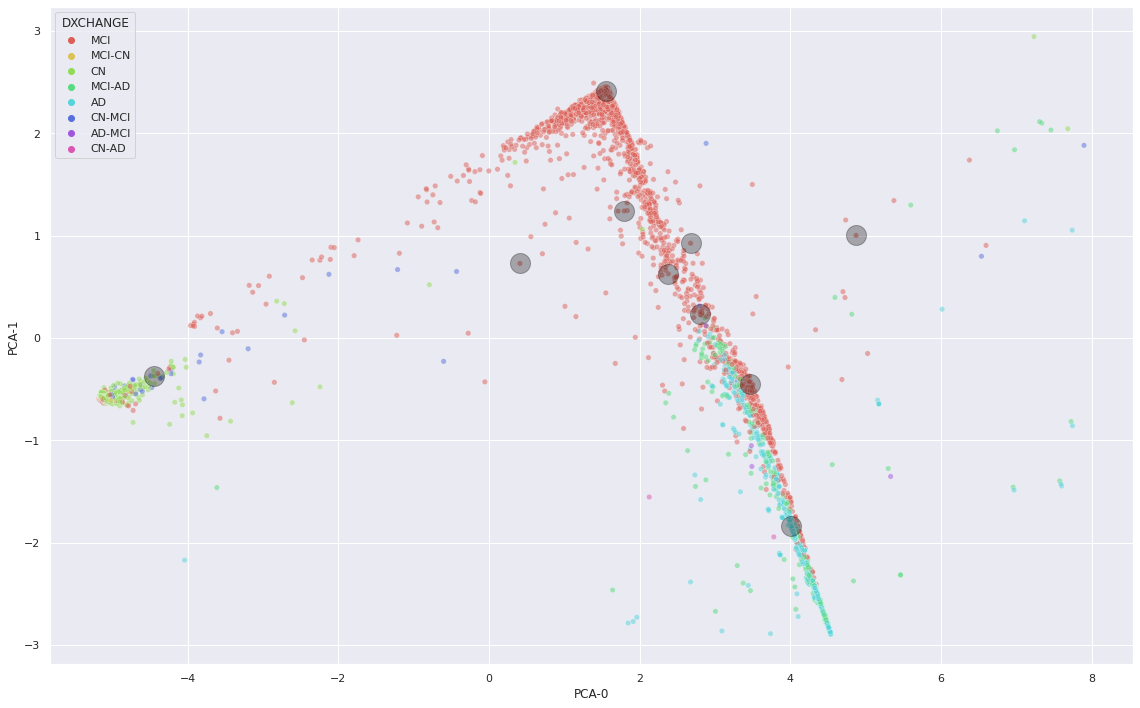

In [74]:
full_pca_result = pca_result.replace({"DXCHANGE":mapping})
plt.figure(figsize=(16,10))
color = "DXCHANGE"
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue=color,  
    #style="PTGENDER",
    s = 30,
    palette=sns.color_palette("hls", 8),
    data=full_pca_result,
    legend="full",
    alpha=0.5
)
# for i in range(n_prototypes, 2*n_prototypes): 
#     print(i)
#     ax.plot([pca_result.iloc[-(i+1),-3]], [pca_result.iloc[-(i+1),-2]], color="blue",marker="o", markersize=20, alpha=0.3)

for i in range(n_prototypes): 
    rid, tp = prototypes_proj[i]
    mask = (pca_result.RID == rid) & (pca_result.TP == tp)
    pca= pca_result[mask][["PCA-0", "PCA-1"]].to_numpy().squeeze()
    print(pca[0])
    ax.plot([prototype_pca.iloc[i,0]], [prototype_pca.iloc[i,1]], color="black",marker="o", markersize=20, alpha=0.3)
    #ax.plot([pca[0]], [pca[1]], color="black",marker="o", markersize=20, alpha=0.3)


plt.tight_layout()
plt.savefig("figures/{}/hidden_states_pca_color_{}{}.png".format(folder, color, ext))

In [506]:
pca_result_ad = pca_result.copy()
#pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE != 5)), 3)
pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE ==5)), 0)
pca_result_ad = pca_result_ad.drop(pca_result_ad[pca_result_ad.DXCHANGE == 0].index)


plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="DXCHANGE",  
    style="PTGENDER",
    s = 30,
    palette="muted",
    data=pca_result_ad,
    legend="full",
    alpha=0.8
)
for i in range(3): 
    ax.plot([prototype_pca.iloc[i,0]], [prototype_pca.iloc[i,1]], color="black",marker="o", markersize=20, alpha=0.3)


In [473]:
pca_result_mci_ad_transitioners = pca_result.copy()
pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.where(pca_result_mci_ad_transitioners.DXCHANGE == 5, 0)
pca_result_mci_ad_transitioners = pca_result_mci_ad_transitioners.drop(pca_result_mci_ad_transitioners[pca_result_mci_ad_transitioners.DXCHANGE == 0].index)


pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.map(mapping)
pca_result_mci_ad_transitioners

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_127,DXCHANGE,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER,cluster,PCA-0,PCA-1,PCA-2
13,514.0,48.0,2.0,1.0,0.000000e+00,0.044375,0.042910,-0.123958,-0.889447,0.032870,...,0.059244,MCI-AD,80.7,29.0,653.6,Male,14.0,1.022628,0.204111,0.849989
27,708.0,24.0,2.0,1.0,1.041201e-07,-0.026811,0.013354,-0.037117,-0.998036,0.000018,...,-0.011878,MCI-AD,76.4,27.0,NaN,Male,8.0,1.769701,-0.385579,0.055895
77,4171.0,24.0,2.0,1.0,-3.161773e-06,-0.008769,0.012085,-0.036598,-0.999935,0.000192,...,-0.011587,MCI-AD,69.4,22.0,NaN,Male,8.0,1.770327,-0.351335,-0.000533
82,4582.0,48.0,2.0,1.0,-4.655953e-06,0.035165,0.036921,-0.091225,-0.999938,0.000179,...,-0.007222,MCI-AD,66.6,21.0,NaN,Female,14.0,1.816959,-0.319671,0.416880
149,223.0,36.0,2.0,1.0,-1.773284e-06,0.032789,0.036509,-0.082341,-0.999747,0.003265,...,0.021255,MCI-AD,78.0,27.0,NaN,Female,14.0,1.698050,-0.251623,0.424047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5632,4414.0,36.0,2.0,1.0,-4.533553e-06,-0.003488,0.035254,-0.036235,-0.999998,0.000002,...,-0.025110,MCI-AD,60.8,21.0,NaN,Female,3.0,2.002241,-0.510869,-0.060059
5642,887.0,18.0,2.0,1.0,-1.776802e-05,0.007745,0.029272,-0.046759,-0.999978,0.000085,...,0.011284,MCI-AD,73.7,17.0,NaN,Female,3.0,1.935275,-0.465397,-0.038501
5666,4157.0,36.0,2.0,1.0,-1.561507e-06,0.026593,0.023329,-0.079221,-0.999872,0.000702,...,0.003300,MCI-AD,81.1,25.0,NaN,Female,14.0,1.819375,-0.360972,0.401114
5706,106.0,108.0,2.0,1.0,-4.390944e-06,-0.024759,0.071548,-0.120723,-0.999836,0.001282,...,0.021021,MCI-AD,73.2,24.0,692.8,Female,14.0,1.805723,-0.299204,0.758016


In [472]:
pca.explained_variance_ratio_

array([0.66298597, 0.25111854, 0.0422773 , 0.01162756])

In [474]:
n_clusters = 4
model = KMeans(n_clusters=n_clusters, init="k-means++", random_state=9)
x = pca_result_mci_ad_transitioners.iloc[:,4:4+128]
model.fit(x)
pca_result_mci_ad_transitioners["cluster"] = model.labels_
pca_result_mci_ad_transitioners.DXCHANGE = 5
prototypes = get_prototypes(model, n_clusters, pca_result_mci_ad_transitioners)
prototypes
for i, p in enumerate(prototypes):    
    mask = pca_result_mci_ad_transitioners.cluster == i
    c = pca_result_mci_ad_transitioners[mask]
    c.to_csv("results/{}/mci_ad_transitioners_{}_cluster_all_{}_{}_{}.csv".format(folder,n_clusters, i, prototypes[i][0], prototypes[i][1]))
prototype_ids = [[rid, tp] for (rid, tp, feat) in prototypes]
prototype_ids

TypeError: get_prototypes() missing 1 required positional argument: 'latent_prototypes'

In [211]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="cluster",  
    style="PTGENDER",
    s = 100,
    palette="muted",
    data=pca_result_mci_ad_transitioners,
    legend="full",
    alpha=0.8
)
for i in range(n_clusters):    
    ax.plot([prototypes[i][2][-3]], [prototypes[i][2][-2]], color="black",marker="o", markersize=20, alpha=0.3)
#ax.get_legend().remove()
plt.tight_layout()
plt.savefig("figures/{}/hidden_states_pca_color_cluster_mci_ad_clustering_{}_all.png".format(folder,n_clusters))


NameError: name 'pca_result_mci_ad_transitioners' is not defined

<Figure size 1152x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

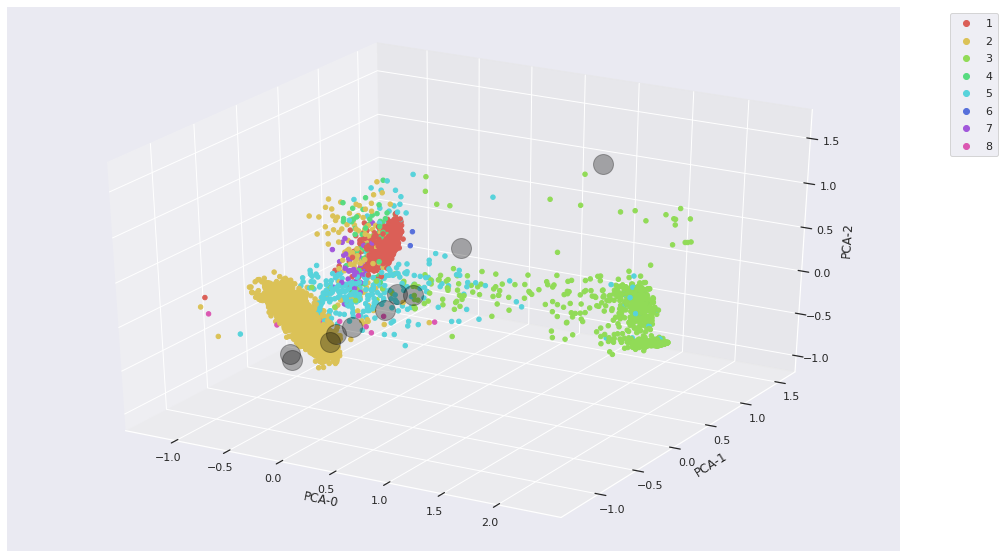

In [18]:
sns.set_style("darkgrid")
fig = plt.figure()


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
sc = ax.scatter(
    xs=pca_result["PCA-0"],
    ys=pca_result["PCA-1"],
    zs=pca_result["PCA-2"],
    c=pca_result["DXCHANGE"], 
    cmap=ListedColormap(sns.color_palette("hls", 8).as_hex()),
    alpha=1
)
for i in range(n_prototypes): 
    ax.plot([prototype_pca.iloc[i,0]], [prototype_pca.iloc[i,1]], [prototype_pca.iloc[i,0]], color="black",marker="o", markersize=20, alpha=0.3)

ax.set_xlabel('PCA-0')
ax.set_ylabel('PCA-1')
ax.set_zlabel('PCA-2')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig("figures/{}/hidden_states_pca_color_{}_{}_3d.png".format(folder, color, ext))